In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter
from pathlib import Path

pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/simclone1000_results'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
!pwd

/Users/JudithAbecassis/Documents/PhD/TCGA_signatures/Clonesig_analysis


In [4]:
clonesig_res = pd.read_csv('20201011_simclone1000_results.csv', sep='\t')
clonesig_res_ith = clonesig_res[clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'tracksig', 'palimpsest', 'dpclust', 'phylogicndt', 'tracksigfreq'])]
clonesig_res_sig = clonesig_res[clonesig_res.method.isin(['clonesig', 'deconstructsigs', 'tracksig', 'palimpsest', 'tracksigfreq'])]
clonesig_res_ith_pyc = clonesig_res[clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'tracksig', 'palimpsest', 'dpclust', 'phylogicndt', 'tracksigfreq', 'pyclone'])]


In [5]:
method_color_dict = {'ccube': '#548ebb', 'clonesig': '#fc9d53',
                     'deconstructsigs':'#793d66', 'palimpsest':'#e45683',
                     'pyclone': '#87d0bd', 'sciclone': '#e1f5aa',
                     'tracksig': '#c4c3f9', 'dpclust': '#90c9e8',
                    'phylogicndt': '#F3BEDF', 'tracksigfreq': '#8942fc'}
legend_keys = {'ccube': 'Ccube', 'tracksig': 'TrackSig',
               'tracksigfreq': 'TrackSigFreq', 'pyclone': 'PyClone',
               'sciclone': 'SciClone', 'palimpsest': 'Palimpsest',
               'deconstructsigs': 'deconstructSigs',
               'phylogicndt': 'PhylogicNDT', 'dpclust': 'DPClust',
               'clonesig': 'CloneSig'}

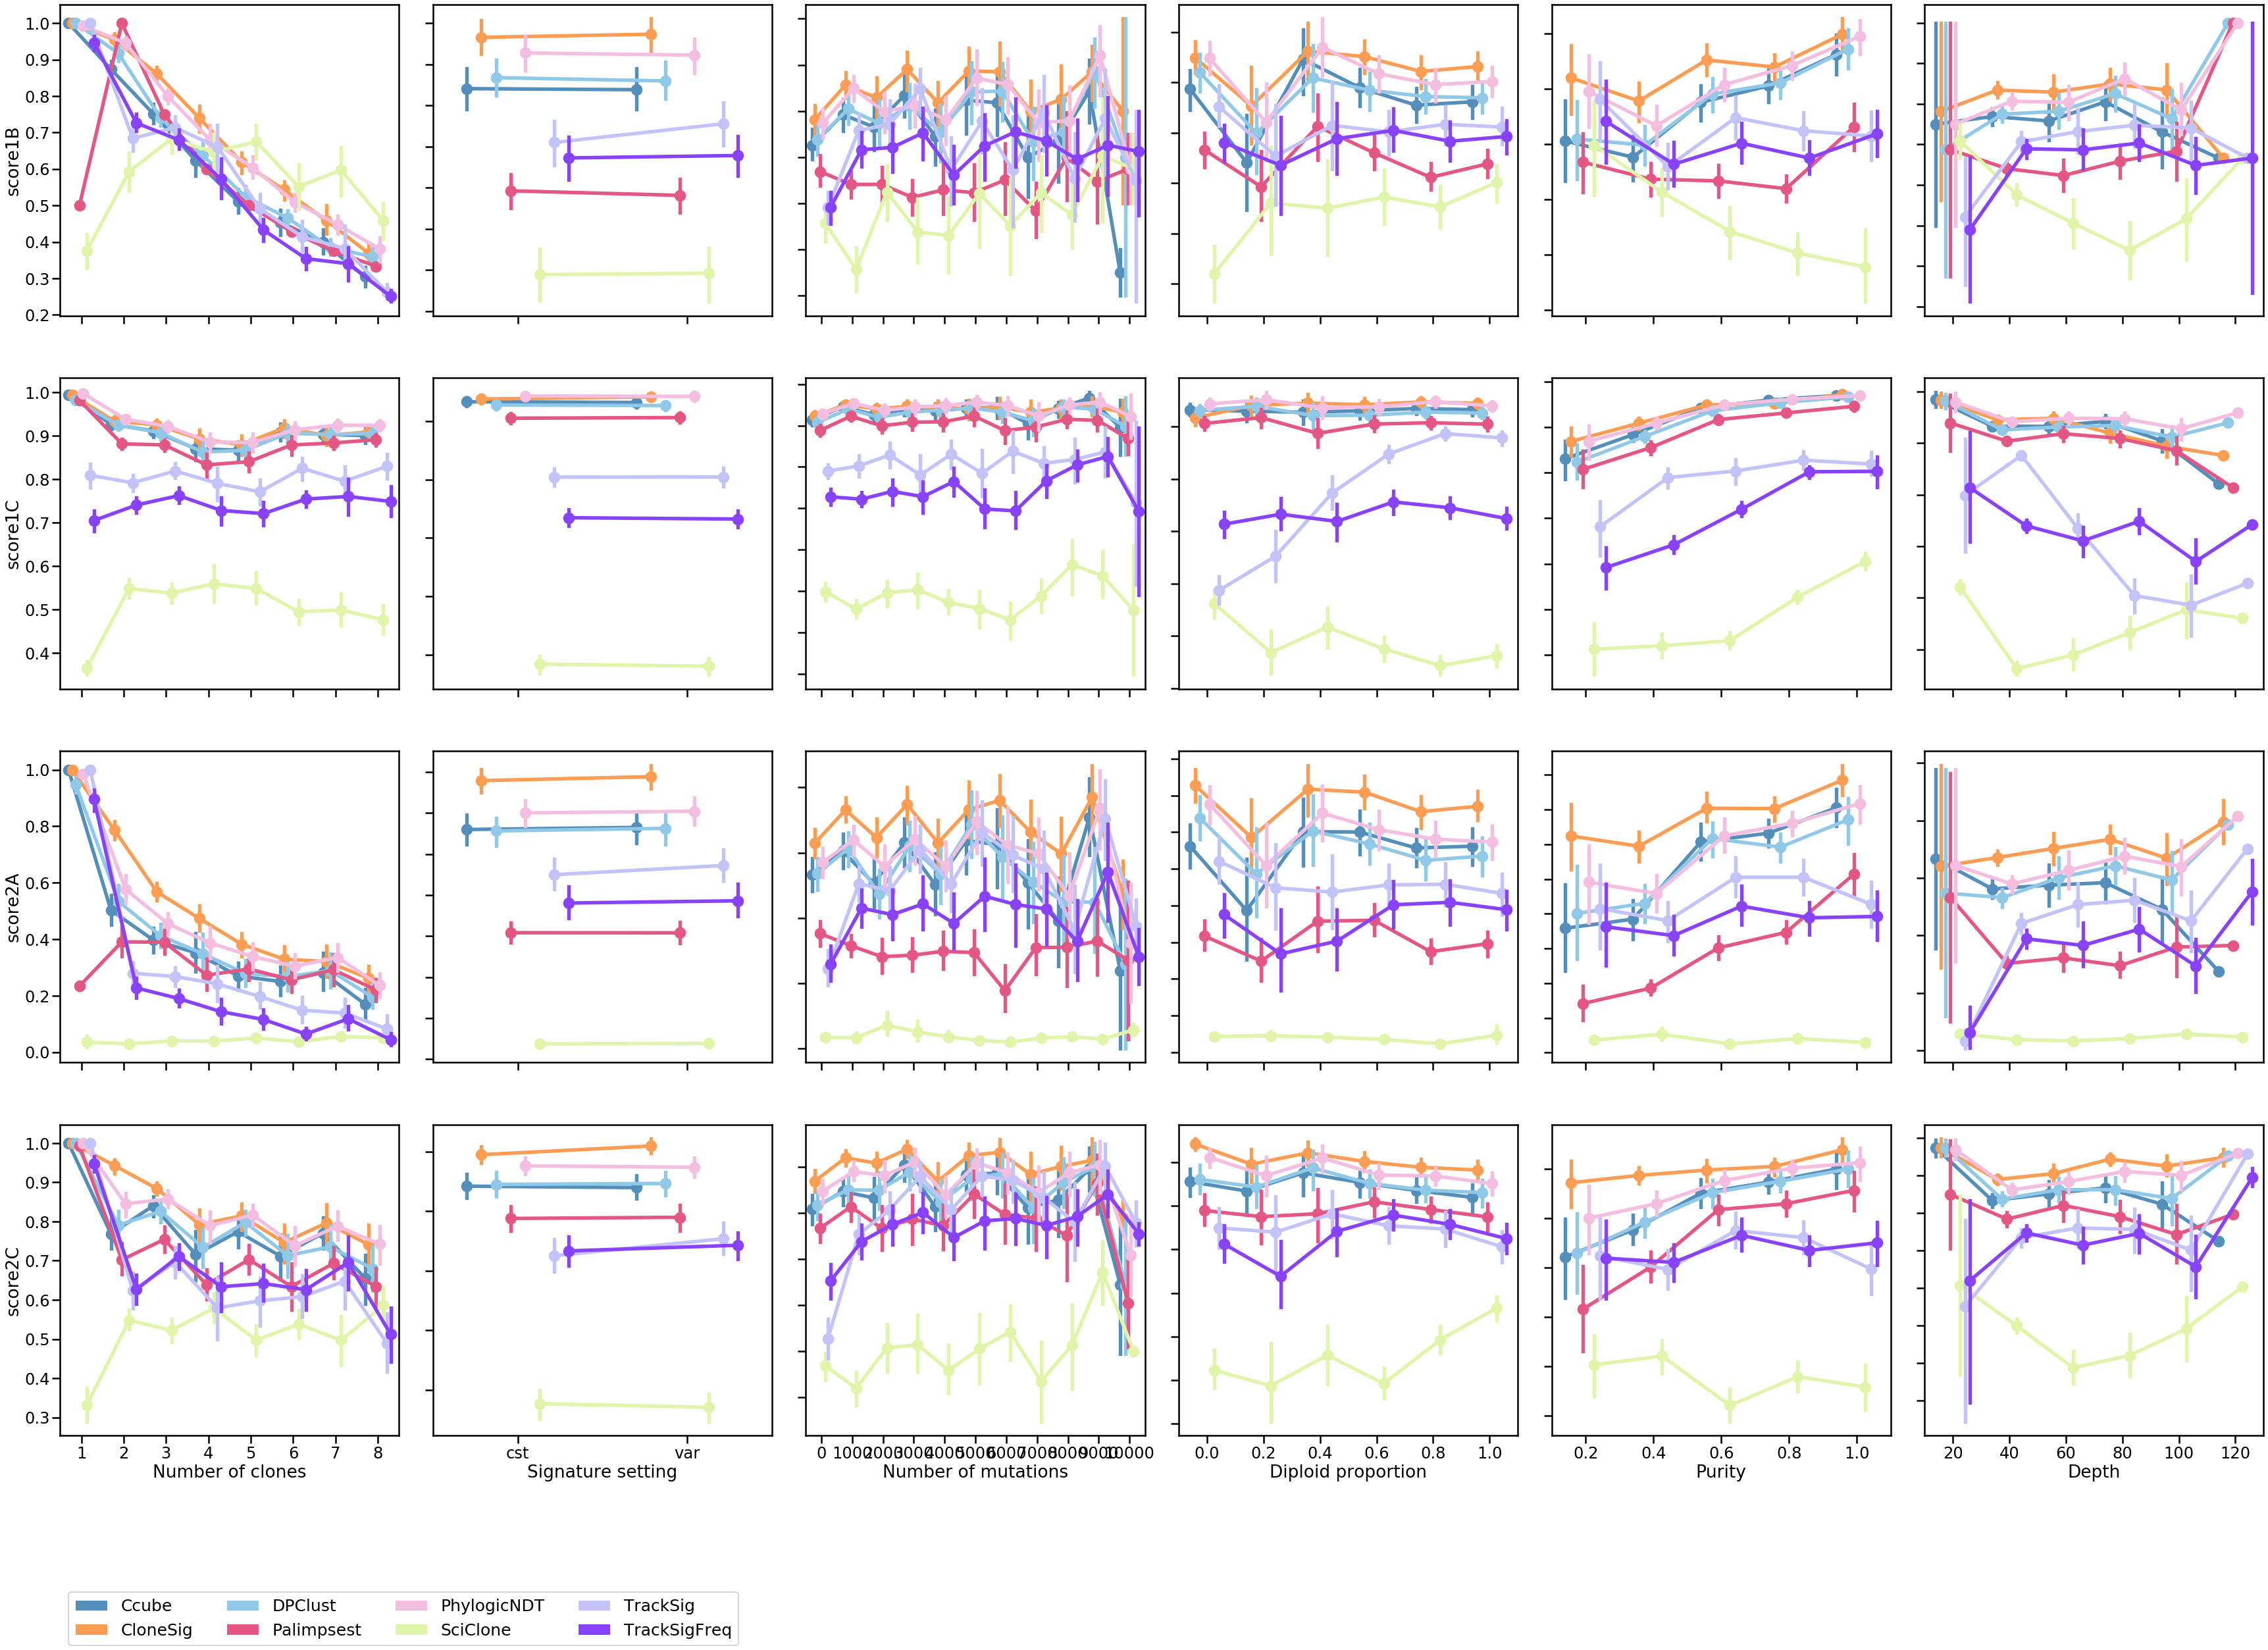

In [6]:
sns.set_context('poster', font_scale=1.1)
id_vars = ['sample', 'var_or_cst']
sub_clonesig_res_ith = clonesig_res_ith.copy()
nice_name = ['Number of clones', 'Signature setting', 'Number of mutations', 'Diploid proportion', 'Purity', 'Depth']
f, axes = plt.subplots(nrows=4, ncols=6, figsize=(60, 40))
sub_clonesig_res_ith = sub_clonesig_res_ith.assign(score2C=sub_clonesig_res_ith.score2C_accuracy)
for ii, score in enumerate(['score1B', 'score1C', 'score2A', 'score2C']):
    
    aa = sub_clonesig_res_ith.dropna(subset=[score]).groupby(id_vars).method.nunique().to_frame().reset_index()
    aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
    sub_clonesig_res_complete = pd.merge(sub_clonesig_res_ith, aa,
                                         on=id_vars)
    sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==8]
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_nb_mut=(np.round(sub_clonesig_res_filter.nb_mut/1000, 0)*1000).astype(int))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_perc_dip=np.round(np.round(sub_clonesig_res_filter.perc_dip/0.2, 0)*0.2, 1))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_purity=np.round(np.round(sub_clonesig_res_filter.true_purity/0.2, 0)*0.2, 1))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_depth=np.round(np.round(sub_clonesig_res_filter.median_depth/20, 0)*20, 0).astype(int))


    for jj, var in enumerate(['true_nb_clones', 'var_or_cst', 'round_nb_mut', 'round_perc_dip', 'round_purity', 'round_depth']):
        sns.pointplot(x=var, y=score, hue="method",
                        data=sub_clonesig_res_filter,
                        hue_order=sorted(sub_clonesig_res_filter.method.unique()),
                       palette=[method_color_dict[i] for i in sorted(sub_clonesig_res_filter.method.unique())],
                         jitter=True, ax=axes[ii, jj], size=10, join=True, dodge=0.6)
        ax = axes[ii, jj]
        if (ii==3) and (jj==0):
            legend_items = list()
            for key in sorted(sorted(sub_clonesig_res_filter.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='white', label=legend_keys[key]))
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(0, -0.7, 1., .102), fontsize=25, loc=3, ncol=4)
        else:
            ax.get_legend().remove()

        if jj!=0:
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
        if ii!=3:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel(nice_name[jj])
plt.subplots_adjust(wspace=0.1)
plt.savefig('{}/all_comp_method_results_ith_only_complete.pdf'.format(output_path), bbox_inches='tight')

In [7]:
sub_clonesig_res_filter[sub_clonesig_res_filter.var_or_cst=='varying']['sample'].nunique()

0

In [8]:
sub_clonesig_res_filter[sub_clonesig_res_filter.var_or_cst=='constant']['sample'].nunique()

0

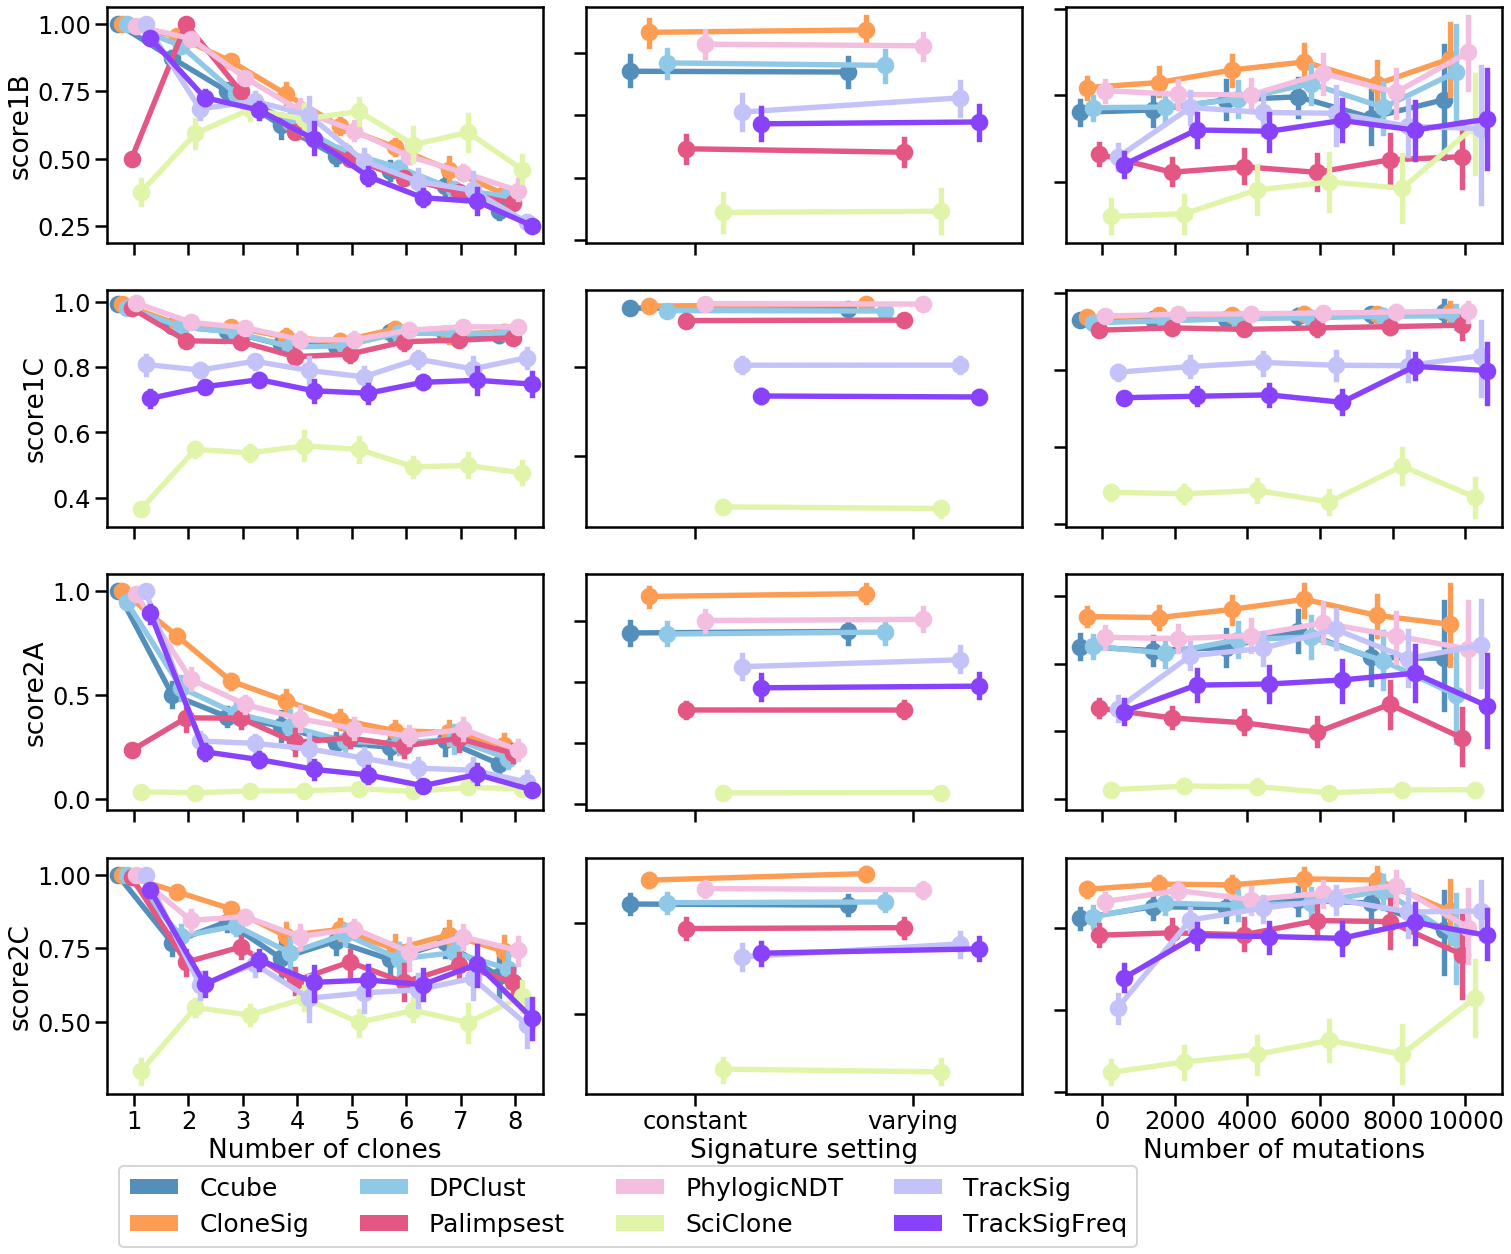

In [9]:
sns.set_context('poster', font_scale=1.1)
id_vars = ['sample', 'var_or_cst']
sub_clonesig_res_ith = clonesig_res_ith.copy()
nice_name = ['Number of clones', 'Signature setting', 'Number of mutations']
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 20))
sub_clonesig_res_ith = sub_clonesig_res_ith.assign(score2C=sub_clonesig_res_ith.score2C_accuracy)
for ii, score in enumerate(['score1B', 'score1C', 'score2A', 'score2C']):
    
    aa = sub_clonesig_res_ith.dropna(subset=[score]).groupby(id_vars).method.nunique().to_frame().reset_index()
    aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
    sub_clonesig_res_complete = pd.merge(sub_clonesig_res_ith, aa,
                                         on=id_vars)
    sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==8]
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_nb_mut=(np.round(sub_clonesig_res_filter.nb_mut/2000, 0)*2000).astype(int))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_perc_dip=np.round(np.round(sub_clonesig_res_filter.perc_dip/0.2, 0)*0.2, 1))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_purity=np.round(np.round(sub_clonesig_res_filter.true_purity/0.2, 0)*0.2, 1))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_depth=np.round(np.round(sub_clonesig_res_filter.median_depth/20, 0)*20, 0).astype(int))
    sub_clonesig_res_filter = sub_clonesig_res_filter.assign(var_or_cst=sub_clonesig_res_filter.var_or_cst.map({'var': 'varying', 'cst': 'constant'}))


    for jj, var in enumerate(['true_nb_clones', 'var_or_cst', 'round_nb_mut']):
        sns.pointplot(x=var, y=score, hue="method",
                        data=sub_clonesig_res_filter,
                        hue_order=sorted(sub_clonesig_res_filter.method.unique()),
                       palette=[method_color_dict[i] for i in sorted(sub_clonesig_res_filter.method.unique())],
                         jitter=True, ax=axes[ii, jj], size=10, join=True, dodge=0.6)
        ax = axes[ii, jj]
        if (ii==3) and (jj==0):
            legend_items = list()
            for key in sorted(sorted(sub_clonesig_res_filter.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='white', label=legend_keys[key]))
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(0, -0.7, 1., .102), fontsize=25, loc=3, ncol=4)
        else:
            ax.get_legend().remove()

        if jj!=0:
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
        if ii!=3:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel(nice_name[jj])
plt.subplots_adjust(wspace=0.1)
plt.savefig('{}/all_comp_method_results_ith_only.pdf'.format(output_path), bbox_inches='tight')

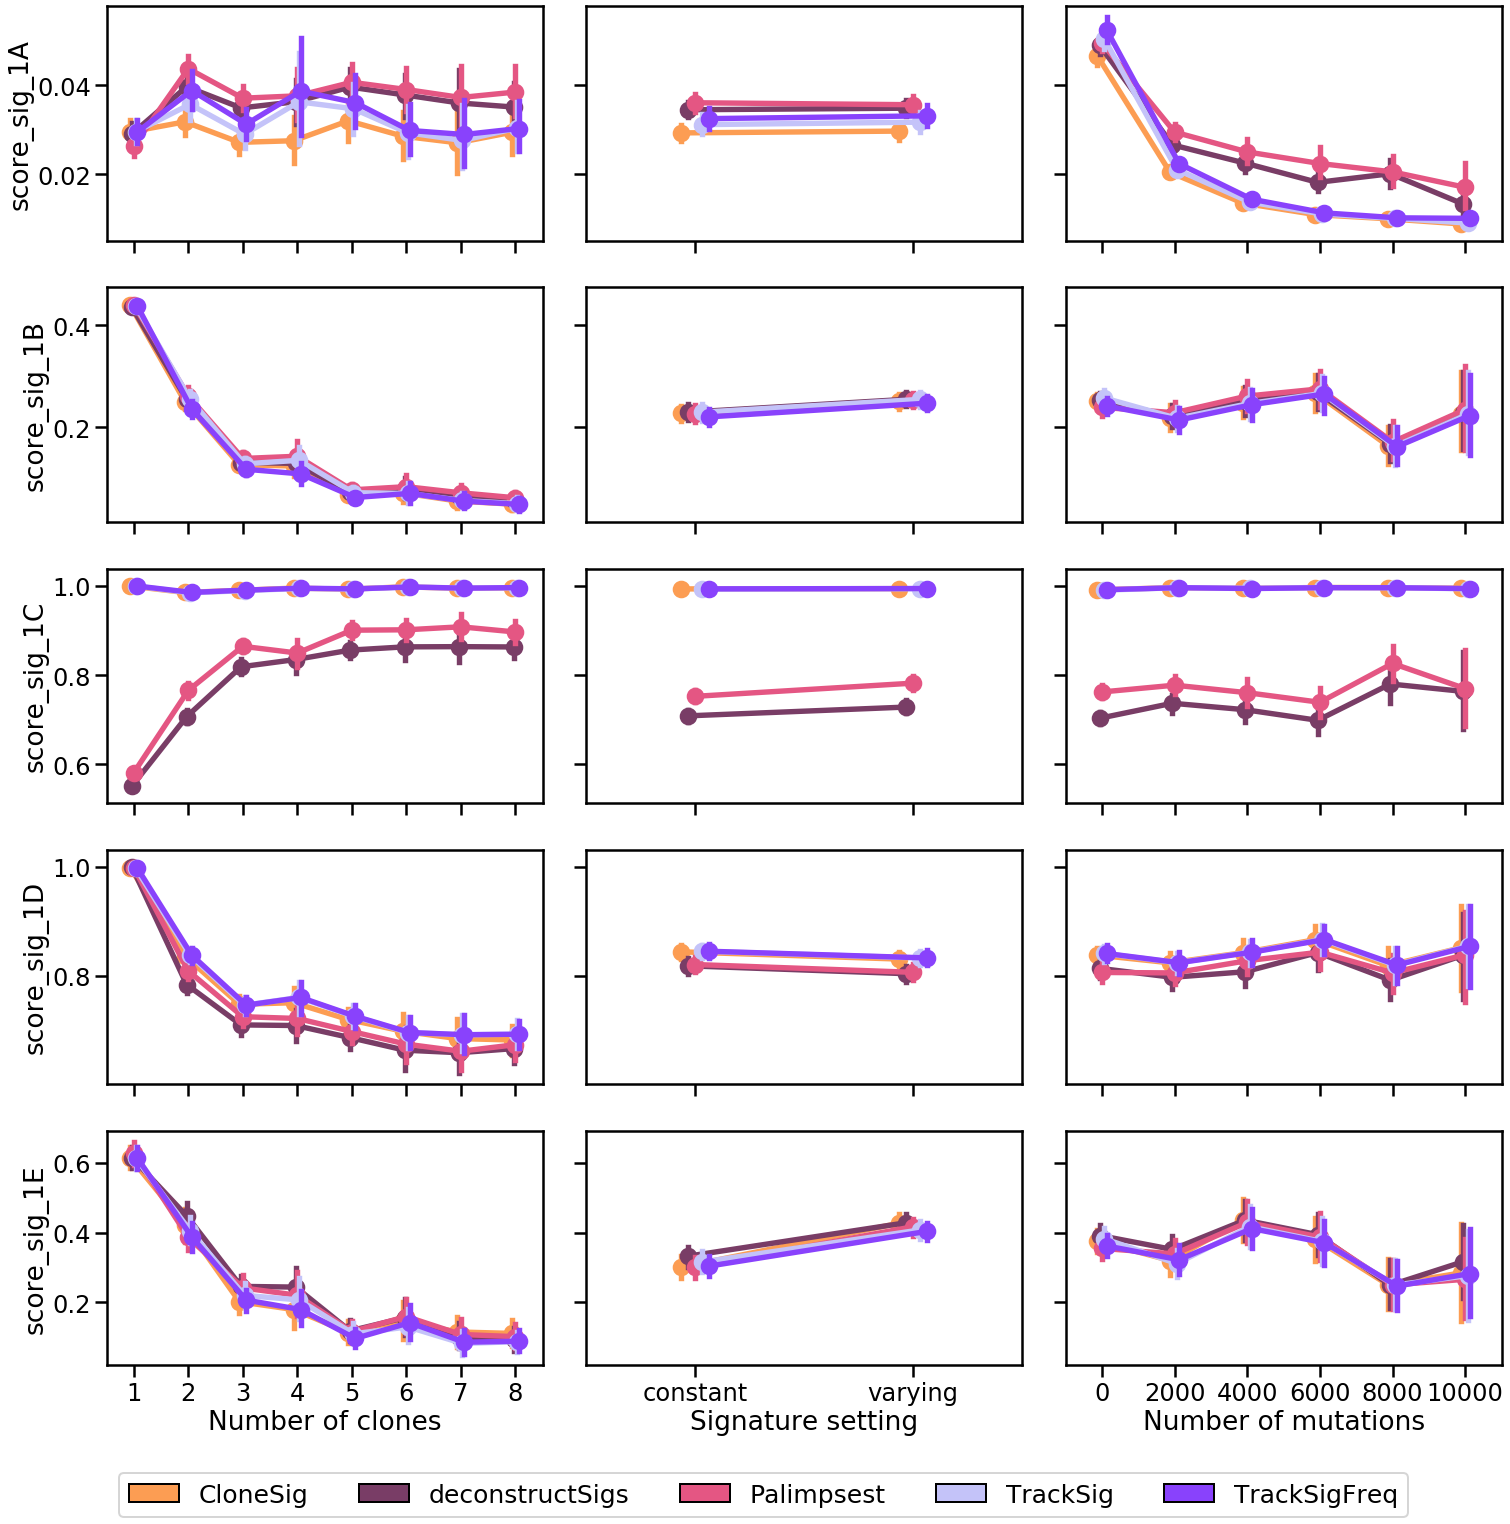

In [10]:
sns.set_context('poster', font_scale=1.1)
nice_name = ['Number of clones', 'Signature setting', 'Number of mutations']
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(25, 25), sharey='row', sharex='col')
clonesig_res_sig_copy = clonesig_res_sig.copy()
clonesig_res_sig_copy = clonesig_res_sig_copy.assign(score_sig_1E=clonesig_res_sig_copy.median_diff_distrib_mut)
clonesig_res_sig_copy = clonesig_res_sig_copy.assign(score_sig_1C=clonesig_res_sig_copy.score_sig_1C_auc)
for ii, score in enumerate(('score_sig_1A', 'score_sig_1B',
                'score_sig_1C', 'score_sig_1D',
                'score_sig_1E')):

    for jj, covariate in enumerate(('true_nb_clones', 'var_or_cst', 'round_nb_mut')):
        if ('sig' in score) or ('score' not in score):
            sub_clonesig_res = clonesig_res_sig_copy
        else:
            sub_clonesig_res = clonesig_res_ith
        if score == 'runtime':
            sub_clonesig_res = clonesig_res

        aa = sub_clonesig_res.groupby(id_vars).method.nunique().to_frame().reset_index()
        aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
        sub_clonesig_res_complete = pd.merge(sub_clonesig_res, aa,
                                             on=id_vars)
        sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==5]
        sub_clonesig_res_filter = sub_clonesig_res_filter.assign(round_nb_mut=(np.round(sub_clonesig_res_filter.nb_mut/2000, 0)*2000).astype(int))
        sub_clonesig_res_filter = sub_clonesig_res_filter.assign(var_or_cst=sub_clonesig_res_filter.var_or_cst.map({'var': 'varying', 'cst': 'constant'}))


        sns.pointplot(x=covariate, y=score, hue="method",
                        data=sub_clonesig_res_filter, palette=[method_color_dict[i.split('-')[0]] for i in sorted(sub_clonesig_res_filter.method.unique())],
                        hue_order=sorted(sub_clonesig_res_filter.method.unique()), ax=axes[ii, jj], dodge=True)

        ax = axes[ii, jj]
        n = len(ax.artists)
        nb_box = sub_clonesig_res_filter.method.nunique()
        labels = sub_clonesig_res_filter.pivot_table(columns=covariate, values=score,
                                             index="method", aggfunc='count')\
            .unstack().dropna().index.to_frame().apply(tuple, axis=1).values
        box_name = sorted(sub_clonesig_res_filter.method.unique())
        
        if (ii==4) and (jj==0):
            legend_items = list()
            for key in sorted(sorted(sub_clonesig_res_filter.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='black', label=legend_keys[key]))
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(0, -0.7, 1., .102), fontsize=25, loc=3, ncol=5)
        else:
            ax.get_legend().remove()

        if jj!=0:
            ax.set_ylabel('')
            #ax.yaxis.set_ticklabels([])
        if ii!=4:
            ax.set_xlabel('')
            #ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel(nice_name[jj])
plt.subplots_adjust(wspace=0.1)
plt.savefig('{}/all_comp_method_results_sig_only.pdf'.format(output_path), bbox_inches='tight')
